# VK friends graph

The goal is to plot a 1.5 friends graph (my friends and their mutual connections)

In [90]:
import vk
import pandas as pd
import numpy as np
import matplotlib
from datetime import datetime
import matplotlib.pyplot as plt

In [129]:
%matplotlib inline
plt.style.use('ggplot')

In [91]:
my_id = 91857120

In [236]:
auth_key = 'YOUR_AUTH_KEY'

In [113]:
session = vk.Session(access_token=auth_key)
api = vk.API(session)

In [115]:
api.users.get(user_id = my_id, fields='sex')

[{'first_name': 'Дмитрiй', 'last_name': 'Сергеевъ', 'sex': 2, 'uid': 91857120}]

In [116]:
fields = 'sex, bdate, city, country, timezone, \
          photo_200_orig, has_mobile, education, relation, status, universities'

In [117]:
friends = pd.DataFrame(api.friends.get(user_id = my_id))

In [118]:
friends.head()

,0
0,173076
1,180827
2,452072
3,546588
4,693176


In [114]:
api.friends.getMutual(source_uid = my_id, target_uid = 173076)

[693176, 14288196]

####I want to know just the amount of mutual friends to assign them as weights of edges of graph

In [119]:
def length_mutual(source_id, target_id):
    return len(api.friends.getMutual(source_uid = source_id, target_uid = target_id))

In [121]:
import time

In [123]:
friends.loc[1, 0]

180827

In [126]:
for i in range(len(friends)):
    time.sleep(0.3)
    try:
        friends.loc[i, 'mutual'] = length_mutual(my_id, friends.loc[i, 0])
    except:
        friends.loc[i, 'mutual'] = 0

In [127]:
friends.head()

,0,mutual
0,173076,2
1,180827,0
2,452072,1
3,546588,1
4,693176,2


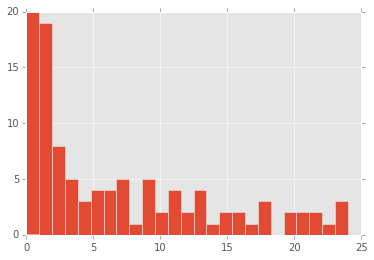

In [133]:
friends.mutual.hist(bins=25)

Apparently, most of my friends do not know each other, 0 or 1 mutual friends are the most frequent :)

In [134]:
friends.mutual.mean()

6.6857142857142859

In [135]:
from sklearn import preprocessing

In [139]:
friends['weights'] = pd.DataFrame(preprocessing.normalize(friends.mutual)).T

C:\Users\Auditore\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [220]:
import networkx as nx
G = nx.Graph()

In [221]:
G.add_node(my_id)

In [222]:
G.add_nodes_from(friends[0])

In [223]:
for i in range(len(friends)):
    G.add_edge(my_id, friends.loc[i, 0], weight = friends.loc[i, 'mutual'])

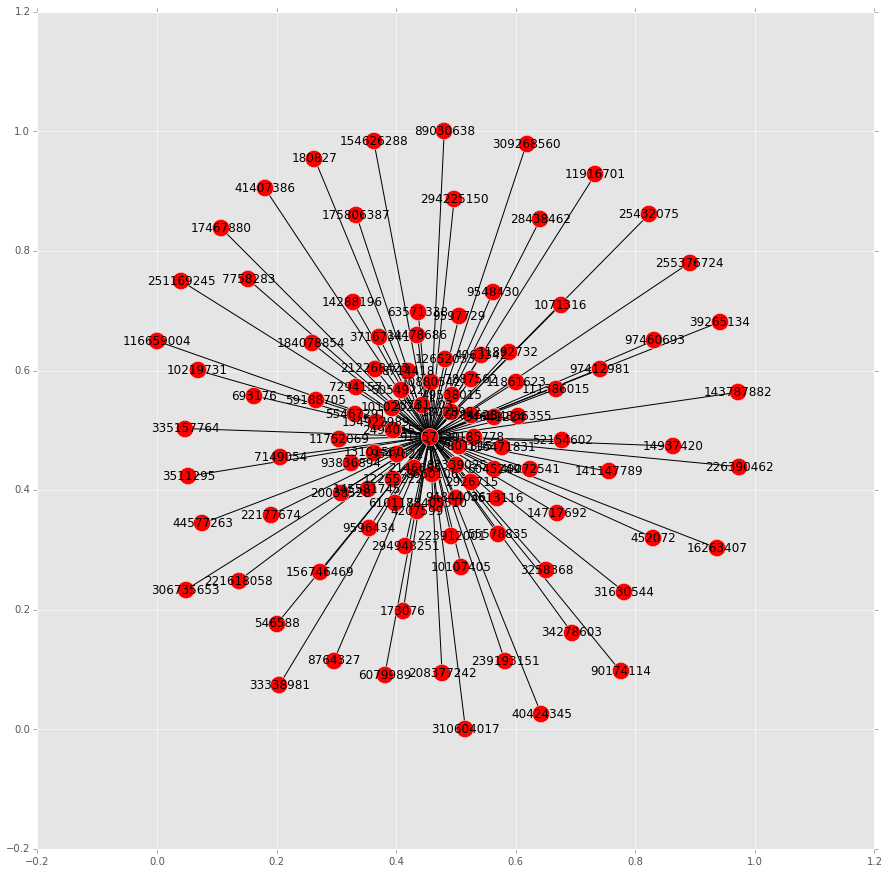

In [224]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G)

In [225]:
friends.head()

,0,mutual,weights
0,173076,2,0.019924
1,180827,0,0.000000
2,452072,1,0.009962
3,546588,1,0.009962
4,693176,2,0.019924


In [226]:
api.friends.getMutual(source_uid = 173076, target_uid = 180827)

[91857120]

In [227]:
173076 in api.friends.get(user_id = 180827)

False

In [228]:
for current_friend in range(len(friends)):
    for check_friend in range(current_friend+1, len(friends)):
        cur_friend = friends.loc[current_friend, 0]
        ch_friend = friends.loc[check_friend, 0]
        time.sleep(0.3)
        try:
            if cur_friend in api.friends.get(user_id = ch_friend):
                G.add_edge(int(cur_friend), int(ch_friend), weight = length_mutual(cur_friend, ch_friend))
        except:
            continue

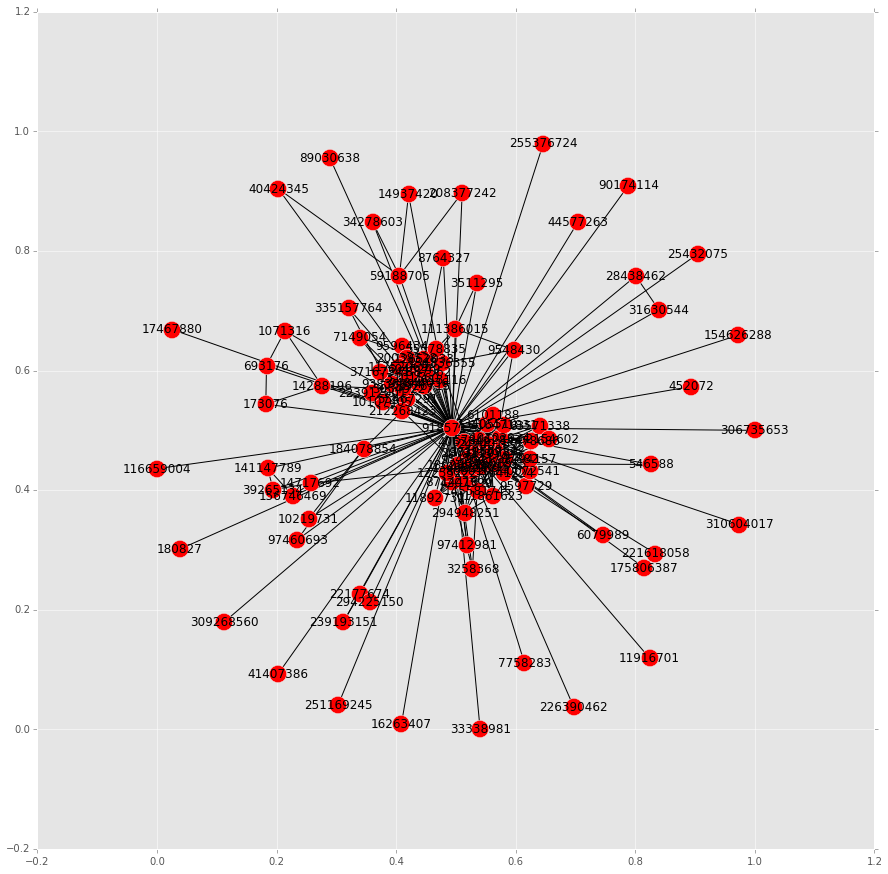

In [235]:
plt.figure(figsize=(15,15))
nx.draw_networkx(G)

In [242]:
nx.average_clustering(G)

0.5743457449078205

## Degree centrality histogram

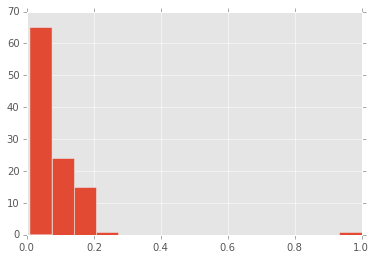

In [267]:
pd.DataFrame(np.array(list(nx.degree_centrality(G).values())))[0].hist(bins=15)

### Number of triangles (for me)

In [273]:
nx.triangles(G)[my_id]

322

In [274]:
nx.transitivity(G)

0.29003757489590737

In [276]:
nx.clustering(G)[my_id]

0.05897435897435897

In [277]:
nx.average_node_connectivity(G)

2.8228212039532794

In [278]:
nx.average_shortest_path_length(G)

1.9232704402515723

In [279]:
nx.diameter(G)

2